In [1]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from preprocess import process_img

# Environment

In [2]:
# Determine if CPU or GPU computation should be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# env = gym.make("CarRacing-v2", domain_randomize=False, continuous=False, render_mode='human')

# # normal reset, this changes the colour scheme by default
# state = env.reset()
# while True:
#     env.render()
#     # take a random action
#     a = env.action_space.sample()
#     state, reward, terminated, truncated, _ = env.step(a)
#     if terminated:
#         break
# env.close() # close and clean up
# # reset with colour scheme change: env.reset(options={"randomize": True})

# # reset with no colour scheme change: env.reset(options={"randomize": False})

In [3]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    
    def reset(self):
        # reset the original environment
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # crop image
        s = process_img(s)
        

        # initial observation is simply a copy of the frame 's'
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))
        return self.stacked_state, info
    
    def step(self, action):
        # Take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        s = process_img(s)

        # push the current frame 's' at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

The shape of an observation:  (4, 42, 42)


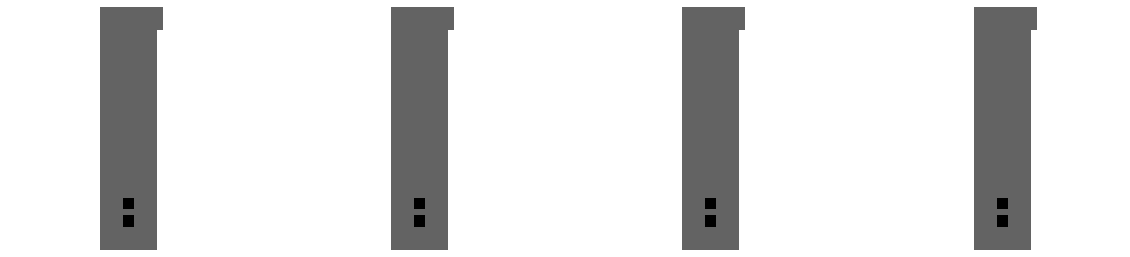

In [4]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Replay Buffer

In [5]:
from collections import deque
class ReplayBuffer:
    """A replay buffer to store experience transition in a fixed capacity"""
    def __init__(self, 
                 capacity: int=1000, 
                 batch_size: int=32,
                 state_shape: list=[4,42,42]):
        self.capacity = capacity
        self.batch_size = batch_size
        self.memory = deque(maxlen=self.capacity)
        
    def store(self, experience) -> None:
        if len(self.memory) > self.capacity:
            del self.memory[0]
        self.memory.append(experience)

    def sample(self):
        """Randomly choose a batch of experience samples from memory"""
        indexes = np.random.choice(np.arange(len(self.memory)), size=self.batch_size, replace=False)
        return [self.memory[i] for i in indexes]

    def __len__(self):
        return len(self.memory)

# Q-Network

In [6]:
class QNetwork(nn.Module):
    def __init__(self, 
                 input_shape: list=[4,42,42],
                 action_dim: int=5):
        """
        input size: 42 * 42 * 4
        after the first convolutional layer: 20 * 20 * 16
        after the second convolutional layer: 9 * 9 * 32
        """
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        
        # determine the shape of conv2 output by a dummy input tensor
        dummy_input = torch.randn(1, *input_shape)
        with torch.no_grad():
            output_shape = torch.flatten(self.conv2(self.conv1(dummy_input))).shape[0]
            
        self.hidden_size = 256
        self.linear1 = nn.Linear(output_shape, self.hidden_size)
        self.classifier = nn.Linear(self.hidden_size, action_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Adjust tensor to have shape [batch, *image_shape]
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        """Forward pass of Q-network"""
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.classifier(x)
        return x

# DQN agent

In [7]:
from torch.utils.data import DataLoader, TensorDataset
class DQNagent:
    """Define the DQN agent and its corresponding methods"""
    def __init__( 
        self, 
        env,
        alpha=0.0001,
        gamma=0.99,
        epsilon=0.1,
        epsilon_min=0.001,
        warm_start=50,
        target_update_freq=100,
        ):
        super().__init__()

        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (self.epsilon - self.epsilon_min)/100000
        
        self.warm_start = warm_start
        self.target_update_freq = target_update_freq
        
        self.buffer = ReplayBuffer()
        
        self.network = QNetwork().to(device)
        self.target_network = QNetwork().to(device)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = optim.RMSprop(self.network.parameters(), self.alpha)
        
        # Define the loss function
        self.loss = nn.MSELoss()
        
        self.total_step = 0
        
    def forward(self, x):
        return self.network(x)        
    
    def add(self, state, action, reward, terminated, next_state):
        self.buffer.store((state, action, reward, terminated, next_state))
        
    def choose_action(self, state):
        state = torch.from_numpy(state).float()
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            with torch.no_grad():
                q_values = self.network.forward(state)
            action = torch.argmax(q_values, dim=1).item()
        
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
        return action
    
    def process(self):
        self.total_step += 1
        if self.total_step >= self.warm_start:
            self.learn()

    def learn(self):
        batch = self.buffer.sample()
        states, actions, rewards, terminates, next_states = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        actions = torch.FloatTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        terminates = torch.FloatTensor(terminates).unsqueeze(1).to(device)

        state_action_values = self.network(states).gather(1, actions.long())
        
        with torch.no_grad():
            best_q_values = self.target_network(next_states)
            y = rewards + self.gamma* (1 - terminates) * torch.max(best_q_values, dim=1, keepdim=True)[0] 
        
        loss = self.loss(state_action_values, y)
        writer.add_scalar('loss', loss.item(), global_step=self.total_step)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update target network
        if self.total_step % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        
        return loss

# Training

In [ ]:
from itertools import count
from tensorboardX import SummaryWriter
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

agent = DQNagent(env)
nepisode = 0
max_step = int(1e4)
writer = SummaryWriter('logs/dqn')
for epoch in count():
    state, _ = env.reset()
    episode_reward = 0
    for time_steps in range(max_step):
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.add(state, action, reward, terminated, next_state)
        episode_reward += reward    
        #train the transition
        agent.process()

        if terminated or truncated:
            break
        else:
            state = next_state
            
    writer.add_scalar('episode reward', episode_reward, global_step=epoch)
    if epoch % 10 == 0:
        torch.save(agent.network.state_dict(), 'dqn-policy.para')
        print('Ep {}\tMoving average score: {:.2f}\tTotal steps: {}\t'.format(epoch, episode_reward, agent.total_step))



Ep 0	Moving average score: 11.46	Total steps: 238	
Ep 10	Moving average score: 49.40	Total steps: 2308	
Ep 20	Moving average score: 377.53	Total steps: 4525	
Ep 30	Moving average score: 632.89	Total steps: 6905	
Ep 40	Moving average score: 467.89	Total steps: 9285	
Ep 50	Moving average score: 685.39	Total steps: 11665	
Ep 60	Moving average score: 699.79	Total steps: 14045	
Ep 70	Moving average score: 653.23	Total steps: 16425	
Ep 80	Moving average score: 679.41	Total steps: 18805	
Ep 90	Moving average score: 640.71	Total steps: 21173	
Ep 100	Moving average score: 737.06	Total steps: 23551	


In [ ]:
# # plot the learning curve
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(episode_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Average Reward')
# plt.show()